In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata

try:
    mnist = fetch_mldata('MNIST original')
except Exception as ex:        
    from six.moves import urllib
    from scipy.io import loadmat
    import os

    mnist_path = os.path.join(".", "datasets", "mnist-original.mat")

    # download dataset from github.
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)

    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Done!")

X = mnist.data / 255.0
y = mnist.target

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print('True shape',X_train.shape, X_test.shape)

#Creating dataset with only 500 features out of 784
feature_set = 400
X_train_reduced = X_train[:,:feature_set]
X_test_reduced = X_test[:,:feature_set]
print('Reduced shape',X_train_reduced.shape, X_test_reduced.shape)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


True shape (49000, 784) (21000, 784)
Reduced shape (49000, 400) (21000, 400)


In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline

import tensorflow as tf
slim = tf.contrib.slim
graph_replace = tf.contrib.graph_editor.graph_replace

import sys, os
sys.path.extend([os.path.expanduser('..')])
from pathint import utils
import seaborn as sns
sns.set_style("ticks")

from tqdm import trange, tqdm

# import operator
import matplotlib.colors as colors
import matplotlib.cm as cmx

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

select = tf.select if hasattr(tf, 'select') else tf.where

# Data params
input_dim = 784
output_dim = 10

# Network params
n_hidden_units = 256
activation_fn = tf.nn.relu

# Optimization params
batch_size = 64
epochs_per_task = 10

n_stats = 1

# Reset optimizer after each age
reset_optimizer = True

from keras.utils import np_utils
#task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9],[1,5],[7,9],[3,8],[0,6],[4,2]]
#task_labels = [[8,9], [6,7], [4,5], [2,3], [0,1]]
#task_labels = [[0,9], [7,8], [3,6], [1,4], [2,5]]
#task_labels = [[0,1,2], [3,4,5], [6,7,8,9]]
#task_labels = [[1,5,8],[2,5,7,9],[3,4,6]]
task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9]]
n_tasks = len(task_labels)
nb_classes  = 10

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Using TensorFlow backend.


In [3]:
def create_dataset(feature_set_reduce_flag=0):
    training_datasets = []
    validation_datasets = []
    multihead=False
    if feature_set_reduce_flag == 1:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=feature_set)

        for labels in task_labels:
            idx = np.in1d(Y_train, labels)
            if multihead:
                label_map = np.arange(nb_classes)
                label_map[labels] = np.arange(len(labels))
                if labels == [0,1] or labels ==[2,3]:
                    data = X_train_reduced[idx], np_utils.to_categorical(label_map[Y_train[idx]], len(labels))
                else:
                    dimesnion_reduced = pca.fit_transform(X_train[idx])
                    data = dimesnion_reduced, np_utils.to_categorical(label_map[Y_train[idx]], len(labels))
            else:
                if labels == [0,1] or labels ==[2,3]:
                    data = X_train_reduced[idx], np_utils.to_categorical(Y_train[idx], nb_classes)
                else:
                    dimesnion_reduced = pca.fit_transform(X_train[idx])
                    data = dimesnion_reduced, np_utils.to_categorical(Y_train[idx], nb_classes)
                training_datasets.append(data)

        for labels in task_labels:
            idx = np.in1d(Y_test, labels)
            if multihead:
                label_map = np.arange(nb_classes)
                label_map[labels] = np.arange(len(labels))
                if labels == [0,1] or labels ==[2,3]:
                    data = X_test_reduced[idx], np_utils.to_categorical(label_map[Y_test[idx]], len(labels))
                else:
                    dimesnion_reduced = pca.fit_transform(X_test[idx])
                    data = dimesnion_reduced, np_utils.to_categorical(label_map[Y_test[idx]], len(labels))
            else:
                if labels == [0,1] or labels ==[2,3]:
                    data = X_test_reduced[idx], np_utils.to_categorical(Y_test[idx], nb_classes)
                else:
                    dimesnion_reduced = pca.fit_transform(X_test[idx])
                    data = dimesnion_reduced, np_utils.to_categorical(Y_test[idx], nb_classes)
                validation_datasets.append(data)
    else:
        training_datasets = utils.construct_split_mnist(task_labels, split='train')
        validation_datasets = utils.construct_split_mnist(task_labels, split='test')
    return(training_datasets,validation_datasets)

tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())
import keras.backend as K
import keras.activations as activations

output_mask = tf.Variable(tf.zeros(output_dim), name="mask", trainable=False)

def masked_softmax(logits):
    # logits are [batch_size, output_dim]
    x = select(tf.tile(tf.equal(output_mask[None, :], 1.0), [tf.shape(logits)[0], 1]), logits, -1e32 * tf.ones_like(logits))
    return activations.softmax(x)

def set_active_outputs(labels):
    new_mask = np.zeros(output_dim)
    for l in labels:
        new_mask[l] = 1.0
    sess.run(output_mask.assign(new_mask))
    print(sess.run(output_mask))
    
def masked_predict(model, data, targets):
    pred = model.predict(data)
    acc = np.argmax(pred,1)==np.argmax(targets,1)
    return acc.mean()

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from pathint import protocols
from pathint.optimizers import KOOptimizer
from keras.optimizers import Adam, RMSprop,SGD
from keras.callbacks import Callback
from pathint.keras_utils import LossHistory
from keras.callbacks import LambdaCallback

def create_model(feature_set_reduce_flag=0):
    model = Sequential()
    if feature_set_reduce_flag == 0:
        model.add(Dense(n_hidden_units, kernel_initializer='random_uniform', activation=activation_fn, input_shape=(input_dim,)))
    else:
        model.add(Dense(n_hidden_units, kernel_initializer='random_uniform', activation=activation_fn, input_shape=(feature_set,)))
    #model.add(Dense(n_hidden_units, kernel_initializer='random_uniform', activation=activation_fn))
    #model.add(Dense(n_hidden_units, activation=activation_fn))
    model.add(Dense(output_dim, kernel_initializer='random_uniform', activation=masked_softmax))

    #protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
    protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
    #protocol_name, protocol = protocols.FISHER_PROTOCOL('sum')
    opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
    #opt = SGD(1e-3)
    #opt = RMSprop(lr=1e-3)
    oopt = KOOptimizer(opt, model=model, **protocol)
    model.compile(loss='categorical_crossentropy', optimizer=oopt, metrics=['accuracy'])
    model.model._make_train_function()
    saved_weights = model.get_weights()
    
    save_weights_epoch=[]
    save_loss_epoch=[]
    print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: save_weights_epoch.append(model.get_weights()))
    history = LossHistory()
    callbacks = [history, print_weights]
    return(model,oopt,callbacks)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
def run_fits(cvals, eval_on_train_set=False, nstats=1, feature_set_reduce=[0]):
    acc_mean = dict()
    acc_std = dict()
    model_weights_save = []   #Empty list to save the model weights aftertraining each task
    for featureset_flag in feature_set_reduce:
        training_data,valid_data = create_dataset(featureset_flag)
        model,oopt,callbacks = create_model(featureset_flag)
        for cidx, cval_ in enumerate(tqdm(cvals)):
            runs = []
            for runid in range(nstats):
                sess.run(tf.global_variables_initializer())
                # model.set_weights(saved_weights)
                cstuffs = []
                evals = []
                print("setting cval")
                cval = cval_
                oopt.set_strength(cval)
                oopt.init_task_vars()
                print("cval is", sess.run(oopt.lam))
                for age, tidx in enumerate(range(n_tasks)):
                    print("Age %i, cval is=%f"%(age,cval))
                    print("settint output mask")
                    set_active_outputs(task_labels[age])
                    stuffs = model.fit(training_data[tidx][0], training_data[tidx][1], batch_size, epochs_per_task, callbacks=callbacks)
                    oopt.update_task_metrics(training_data[tidx][0], training_data[tidx][1], batch_size)
                    oopt.update_task_vars()
                    ftask = []
                    model_weights_save.append(model.get_weights()) #Save the model weights aftertraining each task
                    for j in range(n_tasks):
                        set_active_outputs(task_labels[j])
                        if eval_on_train_set:
                            f_ = masked_predict(model, training_data[j][0], training_data[j][1])
                        else:
                            f_ = masked_predict(model, valid_data[j][0], valid_data[j][1])
                        ftask.append(np.mean(f_))
                    evals.append(ftask)
                    cstuffs.append(stuffs)

                    # Re-initialize optimizater variables
                    if reset_optimizer:
                        oopt.reset_optimizer()

                evals = np.array(evals)
                runs.append(evals)

            runs = np.array(runs)
            acc_mean[featureset_flag] = runs.mean(0)
            acc_std[featureset_flag] = runs.std(0)
    return dict(mean=acc_mean, std=acc_std),model_weights_save,callbacks

In [5]:
# cvals = np.concatenate(([0], np.logspace(-2, 2, 10)))
# cvals = np.concatenate(([0], np.logspace(-1, 2, 2)))
# cvals = np.concatenate(([0], np.logspace(-2, 0, 3)))
#cvals = np.logspace(-3, 3, 7)#[0, 1.0, 2, 5, 10]
cvals = [1.0]
feature_set_reduce = [0,1]
print(feature_set_reduce)

[0, 1]


In [7]:
#%%capture

recompute_data = True

if recompute_data:
    data,model_weights_save ,history= run_fits(cvals, eval_on_train_set=False, nstats=n_stats, feature_set_reduce=feature_set_reduce)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


  0%|          | 0/1 [00:00<?, ?it/s]

setting cval
cval is 1.0
Age 0, cval is=1.000000
settint output mask
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Epoch 1/10
12665/12665 [==============================] - 1s - loss: 0.0267 - acc: 0.9942     
Epoch 2/10
12665/12665 [==============================] - 1s - loss: 0.0031 - acc: 0.9989     
Epoch 3/10
12665/12665 [==============================] - 1s - loss: 0.0019 - acc: 0.9994     
Epoch 4/10
12665/12665 [==============================] - 1s - loss: 0.0012 - acc: 0.9996      
Epoch 5/10
12665/12665 [==============================] - 1s - loss: 0.0011 - acc: 0.9994        
Epoch 6/10
12665/12665 [==============================] - 1s - loss: 4.9851e-04 - acc: 0.9998     
Epoch 7/10
12665/12665 [==============================] - 1s - loss: 2.0938e-04 - acc: 0.9999     
Epoch 8/10
12665/12665 [==============================] - 1s - loss: 1.4401e-04 - acc: 1.0000     
Epoch 9/10
12665/12665 [==============================] - 1s - loss: 5.1291e-05 - acc: 1.0000     
Epoch 10/10
12665/12665 

  0%|          | 0/1 [00:00<?, ?it/s]

setting cval
cval is 1.0
Age 0, cval is=1.000000
settint output mask
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Epoch 1/10
10447/10447 [==============================] - 0s - loss: 0.0508 - acc: 0.9907     
Epoch 2/10
10447/10447 [==============================] - 0s - loss: 0.0067 - acc: 0.9978     
Epoch 3/10
10447/10447 [==============================] - 0s - loss: 0.0046 - acc: 0.9984     
Epoch 4/10
10447/10447 [==============================] - 0s - loss: 0.0026 - acc: 0.9992     
Epoch 5/10
10447/10447 [==============================] - 0s - loss: 0.0018 - acc: 0.9993     
Epoch 6/10
10447/10447 [==============================] - 0s - loss: 0.0029 - acc: 0.9988     
Epoch 7/10
10447/10447 [==============================] - 0s - loss: 0.0011 - acc: 0.9996     
Epoch 8/10
10447/10447 [==============================] - 0s - loss: 0.0012 - acc: 0.9993     
Epoch 9/10
10447/10447 [==============================] - 0s - loss: 0.0010 - acc: 0.9996     
Epoch 10/10
10447/10447 [===================

100%|██████████| 1/1 [00:36<00:00, 36.86s/it]

[0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


In [8]:
import h5py
print(create_model(1)[0].summary())

#Shape of the array containg model weights
weights = create_model(1)[0].get_weights()
for i in range(len(weights)):
    print((np.array(weights[i])).shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               102656    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2570      
Total params: 105,226
Trainable params: 105,226
Non-trainable params: 0
_________________________________________________________________
None
(400, 256)
(256,)
(256, 10)
(10,)


In [9]:
#Inspection of behavior of importance parameter big_omega after every task 
from numpy import count_nonzero
last_epoch_batchindex = []
counter = 0
for i,j in enumerate(history[0].batchindex):
    try:
        if history[0].batchindex[i+1] > j:
            pass
        else:
            counter = counter+1
            if counter%epochs_per_task == 0:
                last_epoch_batchindex.append(i)
    except:
        last_epoch_batchindex.append(i)

print('Batch-id for last epoch of each task:',last_epoch_batchindex)
print('*----------------------------*')
for i,epoch_id in enumerate(last_epoch_batchindex):
    key = list(history[0].big_omega[epoch_id].keys())
    print('Parameter importance (big_omega) for task {0} shape is '.format(i), [history[0].big_omega[epoch_id][ke].shape for ke in key]) 

non_zero_imp_param = []
print('*----------------------------*')
for i,epoch_id in enumerate(last_epoch_batchindex):
    key = list(history[0].big_omega[epoch_id].keys())
    non_zero_imp_param.append(sum([count_nonzero(history[0].big_omega[epoch_id][ke]) for ke in key]))
    print('Number of non-zero elements of importance (big_omega) for task {0} is '.format(i), non_zero_imp_param[i])    

Batch-id for last epoch of each task: [1639, 3189, 4619, 6169, 7689]
*----------------------------*
Parameter importance (big_omega) for task 0 shape is  [(400, 256), (10,), (256,), (256, 10)]
Parameter importance (big_omega) for task 1 shape is  [(400, 256), (10,), (256,), (256, 10)]
Parameter importance (big_omega) for task 2 shape is  [(400, 256), (10,), (256,), (256, 10)]
Parameter importance (big_omega) for task 3 shape is  [(400, 256), (10,), (256,), (256, 10)]
Parameter importance (big_omega) for task 4 shape is  [(400, 256), (10,), (256,), (256, 10)]
*----------------------------*
Number of non-zero elements of importance (big_omega) for task 0 is  0
Number of non-zero elements of importance (big_omega) for task 1 is  76111
Number of non-zero elements of importance (big_omega) for task 2 is  84600
Number of non-zero elements of importance (big_omega) for task 3 is  104196
Number of non-zero elements of importance (big_omega) for task 4 is  104710


In [10]:
def flatten(x):
    try:
        it = iter(x)
    except TypeError:
        yield x
    else:
        for i in it:
            for j in flatten(i):
                yield j
                
mean_std_imp_param = []
flat_list_imp_param = []
print('*----------------------------*')
for i,epoch_id in enumerate(last_epoch_batchindex):
    key = list(history[0].big_omega[epoch_id].keys())
    for ke in key:
        flat_list_imp_param.append(history[0].big_omega[epoch_id][ke]) 
    flat_list_imp_param = list(flatten(flat_list_imp_param))
    mean = np.mean(flat_list_imp_param)
    std = np.std(flat_list_imp_param)
    imp_threshold = np.abs(mean - std)
    mean_std_imp_param = [elem for elem in flat_list_imp_param if elem > imp_threshold ]  
    print('Mean: {}, Std: {}, Imp threshold: {}, Number of imp param: {}'.format(mean, std, imp_threshold, len(mean_std_imp_param)))
    flat_list_imp_param = []

*----------------------------*
Mean: 0.0, Std: 0.0, Imp threshold: 0.0, Number of imp param: 0
Mean: 0.008034752681851387, Std: 0.018351484090089798, Imp threshold: 0.010316731408238411, Number of imp param: 23835
Mean: 0.14342069625854492, Std: 0.3768022358417511, Imp threshold: 0.23338153958320618, Number of imp param: 17292
Mean: 0.15328548848628998, Std: 0.3742614984512329, Imp threshold: 0.22097600996494293, Number of imp param: 18275
Mean: 0.1909303069114685, Std: 0.37072548270225525, Imp threshold: 0.17979517579078674, Number of imp param: 27146


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


(-5.0, 0.0)


/usr/local/lib/python3.5/dist-packages/matplotlib/tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


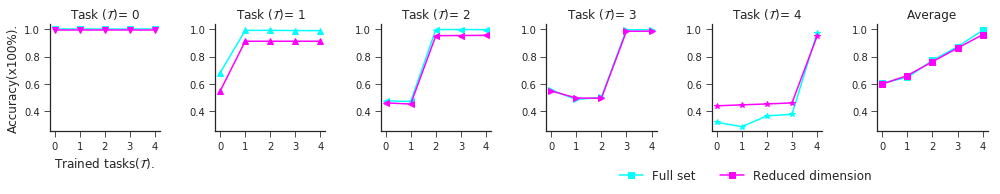

In [8]:
import matplotlib.colors as colors
cmap = plt.get_cmap('cool') 
cNorm  = colors.Normalize(vmin=-5, vmax=np.log(np.max(list(data['mean'].keys()))))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
print(scalarMap.get_clim())
fontsize =12

figure(figsize=(14, 3))
axs = [subplot(1,n_tasks+1,1)]#, None, None]
for i in range(1, n_tasks + 1):
    axs.append(subplot(1, n_tasks+1, i+1, sharex=axs[0], sharey=axs[0]))
    
keys = list(data['mean'].keys())
sorted_keys = np.sort(keys)
marker=["v","^","<",">","*","s"]

for feature_set_flag in sorted_keys:
    mean_vals = data['mean'][feature_set_flag]
    std_vals = data['std'][feature_set_flag]
    for j in range(n_tasks):
        colorVal = scalarMap.to_rgba(np.log(feature_set_flag))
        # axs[j].plot(evals[:, j], c=colorVal)
        axs[j].errorbar(range(n_tasks), mean_vals[:, j], yerr=std_vals[:, j]/np.sqrt(n_stats), c=colorVal, marker=marker[j])
        axs[j].set_xticks(range(n_tasks))
        axs[j].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        axs[0].set_xlabel("Trained tasks($\mathcal{T}$).",fontsize=fontsize)
        axs[0].set_ylabel('Accuracy(x100%).',fontsize=fontsize)
    label = ['Full set', 'Reduced dimension']
    average = mean_vals.mean(1)  #Taking the average of cross validation accuracies accross all tasks after learning each task
    axs[-1].plot(average, c=colorVal, label=label[feature_set_flag], marker=marker[j+1])
    
for i, ax in enumerate(axs):
    ax.legend(loc='upper right',prop={'size': fontsize}, bbox_to_anchor=(0.05, -0.25), ncol=2)
    ax.set_title((['Task ($\mathcal{T}$)= %d'%j for j in range(n_tasks)] + ['Average'])[i])
gcf().tight_layout()
sns.despine()
plt.savefig('MNIST-Progressive-Transfer-Learning.pdf')

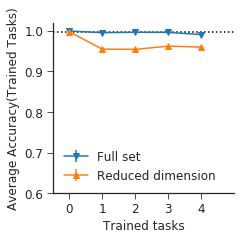

In [9]:
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

def simple_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
fig = plt.figure(figsize=(3.0,3.0))
ax = plt.subplot(111)

plot_keys =sorted(data['mean'].keys())# [0,1]

for cval in plot_keys:
    mean_stuff = []
    std_stuff = []
    for i in range(len(data['mean'][cval])):
        mean_stuff.append(data['mean'][cval][i][:i+1].mean())
        std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))
    label = ['Full set', 'Reduced dimension']
    errorbar(range(0,n_tasks), mean_stuff, yerr=std_stuff, marker=marker[cval], label=label[cval])
        
axhline(data['mean'][cval][0][0], linestyle=':', color='k')
xlabel('Trained tasks', fontsize=fontsize)
ylabel('Average Accuracy(Trained Tasks)', fontsize=fontsize)
legend(loc='best', fontsize=fontsize)
xlim(-0.5, n_tasks)
plt.yticks([0.6,0.7,0.8,0.9,1.0], fontsize=fontsize)
plt.xticks(range(0,n_tasks), fontsize=fontsize)
ylim(0.6, 1.02)
# grid('on')
# sns.despine()
simple_axis(ax)
plt.subplots_adjust(left=.15, bottom=.18, right=.99, top=.97)
plt.savefig("MNIST_avg_accuracy.pdf",bbox_inches = "tight")

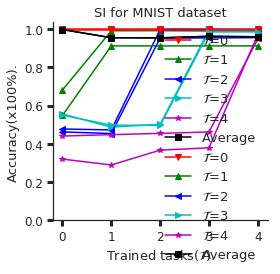

In [10]:
import pdb
figure(figsize=(4, 4))
axs = [subplot(1,1,1)]#, None, None]
fontsize = 13

keys = list(data['mean'].keys())
sorted_keys = np.sort(keys)

colorVal = ['r','g','b','c','m','k','y']
marker=["v","^","<",">","*","s"]

mean_stuff=[]
std_stuff=[]
for i in range(len(data['mean'][cval])):
    mean_stuff.append(data['mean'][cval][i][:i+1].mean())
    std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))

for cval in sorted_keys:
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks):
        label = "$\mathcal{T}$=%g"%j
        axs[0].plot(range(n_tasks), mean_vals[:, j], marker=marker[j], c=colorVal[j], label=label)
    axs[0].plot(range(n_tasks), mean_stuff, marker=marker[j+1], c=colorVal[j+1], label='Average')
    axs[0].legend(loc='best',prop={'size': fontsize})
    axs[0].set_xlabel("Trained tasks($\mathcal{T}$).",fontsize=fontsize)
    axs[0].set_ylabel('Accuracy(x100%).',fontsize=fontsize)
    axs[0].set_xticks(range(n_tasks))
    axs[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    axs[0].tick_params(labelsize='large', width=3)
    axs[0].set_title('SI for MNIST dataset', fontsize=fontsize)

gcf().tight_layout()
sns.despine()
plt.savefig('MNIST_SI_feature_expansion.pdf')

In [6]:
#Before reducing dataset.
print('Before reduction.')
training_datasets,_ = create_dataset(feature_set_reduce_flag=0)
for j in range(n_tasks):
    print('Rank of data for task-{0} of shape-{1} is: {2}'.format(j,training_datasets[j][0][:,:feature_set].shape,matrix_rank(np.matrix(training_datasets[j][0][:,:feature_set], dtype='float'))))
    print('----------------------------------------------------------------------')

Before reduction.
Rank of data for task-0 of shape-(12665, 400) is: 297
----------------------------------------------------------------------
Rank of data for task-1 of shape-(12089, 400) is: 314
----------------------------------------------------------------------
Rank of data for task-2 of shape-(11263, 400) is: 293
----------------------------------------------------------------------
Rank of data for task-3 of shape-(12183, 400) is: 338
----------------------------------------------------------------------
Rank of data for task-4 of shape-(11800, 400) is: 276
----------------------------------------------------------------------


In [12]:
#After Reducing dataset to 400 features.
print('After reduction.')
training_datasets,_ = create_dataset(feature_set_reduce_flag=1)
for j in range(n_tasks):
    print('Rank of data for task-{0} of shape-{1} is: {2}'.format(j,training_datasets[j][0].shape,matrix_rank(np.matrix(training_datasets[j][0], dtype='float'))))
    print('----------------------------------------------------------------------')

After reduction.
Rank of data for task-0 of shape-(10447, 400) is: 292
----------------------------------------------------------------------
Rank of data for task-1 of shape-(9893, 400) is: 314
----------------------------------------------------------------------
Rank of data for task-2 of shape-(9119, 400) is: 400
----------------------------------------------------------------------
Rank of data for task-3 of shape-(9871, 400) is: 400
----------------------------------------------------------------------
Rank of data for task-4 of shape-(9670, 400) is: 400
----------------------------------------------------------------------


In [13]:
#Rank of extended features
training_datasets,_ = create_dataset(feature_set_reduce_flag=0)
for j in range(n_tasks):
    print('Rank of extended features for task-{0} of shape-{1} is: {2}'.format(j,training_datasets[j][0][:,feature_set:].shape,matrix_rank(np.matrix(training_datasets[j][0][:,feature_set:], dtype='float'))))
    print('----------------------------------------------------------------------')

Rank of extended features for task-0 of shape-(12665, 384) is: 285
----------------------------------------------------------------------
Rank of extended features for task-1 of shape-(12089, 384) is: 323
----------------------------------------------------------------------
Rank of extended features for task-2 of shape-(11263, 384) is: 313
----------------------------------------------------------------------
Rank of extended features for task-3 of shape-(12183, 384) is: 330
----------------------------------------------------------------------
Rank of extended features for task-4 of shape-(11800, 384) is: 318
----------------------------------------------------------------------
